# DuckDB + Spatial Extension Scalability Test
This notebook benchmarks the scalability of DuckDB Spatial using real city data from OpenStreetMap.
We test with increasing urban complexity: Pinerolo, Milano, Roma and Tokyo.

In [2]:
# Import libraries
import os
import time
import duckdb
import osmnx as ox
import networkx as nx
import pandas as pd
from shapely import wkt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="osmnx._overpass")

---

## Starting the main benchmark test

The test needs some nominal and type adjustments before its start.

We use overpass to get direct access to every OpenStreetMap data.

In [3]:
# Prepare DuckDB with spatial extension
con = duckdb.connect('data/benchmark/benchmark.duckdb')
con.execute("INSTALL spatial;")
con.execute("LOAD spatial;")

# Define cities to benchmark
cities = ["Pinerolo, Piemonte, Italy", "Milano, Lombardia, Italy", "Roma, Lazio, Italy", "Tokyo, Japan"]
results = []
import_times = []

# Normalize a city name to use as table suffix
def normalize_city_name(city):
    return city.lower().replace(",", "").replace(" ", "_")

For every city defined before we are going to get their polygon from OSM via osmnx and to convert their geometries to WKT (Well-Know Text = representing vector geometry objects).

Then we create the tables into the database for every city and we calculate every major information about the city loading (Number of Nodes, Number of Edges, Query Time, Memory Usage in the DataBase, Import Time).

We even load every data found into a .csv file to analyze them better.

In [3]:
# Loop over each city to download, process, and insert data
for city in cities:
    print(f"\nProcessing {city}...")

    ox.settings.overpass_endpoint = "https://overpass.kumi.systems/api"
    table_suffix = normalize_city_name(city)

    try:
        # Start timing
        start = time.time()

        # Get city polygon
        gdf = ox.geocode_to_gdf(city)
        polygon = gdf.loc[0, 'geometry']

        # Download street network
        G = ox.graph_from_polygon(polygon, network_type='drive')

        # Project the graph to a coordinate system with meters (e.g., UTM)
        G_projected = ox.project_graph(G)

        # Convert graph to GeoDataFrames
        nodes, edges = ox.graph_to_gdfs(G_projected)

        # Convert geometries to WKT
        nodes['geometry_wkt'] = nodes['geometry'].apply(lambda geom: geom.wkt)
        edges['geometry_wkt'] = edges['geometry'].apply(lambda geom: geom.wkt)

        # Clean and register dataframes, dropping geometry column
        nodes_clean = nodes.drop(columns=['geometry']).copy()
        edges_clean = edges.drop(columns=['geometry']).copy()

        # Convert problematic columns (like arrays or mixed types) to strings
        for df in [nodes_clean, edges_clean]:
            for col in df.columns:
                if df[col].apply(lambda x: isinstance(x, list)).any():
                    df[col] = df[col].astype(str)

        con.register('nodes_df', nodes_clean)
        con.register('edges_df', edges_clean)

        # Create dedicated tables per city
        con.execute(f"""
            CREATE TABLE IF NOT EXISTS nodes_{table_suffix} AS
            SELECT ROW_NUMBER() OVER() AS node_id, * FROM nodes_df WHERE FALSE;
        """)
        con.execute(f"""
            INSERT INTO nodes_{table_suffix}
            SELECT ROW_NUMBER() OVER() AS node_id, * FROM nodes_df;
        """)

        con.execute(f"""
            CREATE TABLE IF NOT EXISTS edges_{table_suffix} AS
            SELECT ROW_NUMBER() OVER() AS edge_id, * FROM edges_df WHERE FALSE;
        """)
        con.execute(f"""
            INSERT INTO edges_{table_suffix}
            SELECT ROW_NUMBER() OVER() AS edge_id, * FROM edges_df;
        """)

        # Time spatial query for benchmark test (calculate avg, max and min length of the edges of any city)
        start_query = time.time()
        con.execute(f"""
            SELECT
                AVG(ST_Length(ST_GeomFromText(geometry_wkt))) AS avg_length,
                MAX(ST_Length(ST_GeomFromText(geometry_wkt))) AS max_length,
                MIN(ST_Length(ST_GeomFromText(geometry_wkt))) AS min_length
            FROM edges_{table_suffix}
            WHERE geometry_wkt IS NOT NULL;
        """)
        query_time = time.time() - start_query

        # Measure DB file size
        db_size = os.path.getsize("data/benchmark/benchmark.duckdb") / (1024 ** 2)  # MB

        # Stop timing
        import_time = time.time() - start

        # Save result
        results.append({
            'City': city,
            'Nodes': len(nodes),
            'Edges': len(edges),
            'Query Time (s)': round(query_time, 3),
            'DB Size (MB)': round(db_size, 2),
            'Import Time (s)': round(import_time, 2),
        })

    except Exception as e:
        print(f"Error processing {city}: {e}")

# Show results
summary = pd.DataFrame(results)
print(summary)

# Save summary to CSV
summary.to_csv("data/benchmark/duckdb_scalability_summary.csv", index=False)


Processing Pinerolo, Piemonte, Italy...

Processing Milano, Lombardia, Italy...

Processing Roma, Lazio, Italy...

Processing Tokyo, Japan...
                        City   Nodes   Edges  Query Time (s)  DB Size (MB)  \
0  Pinerolo, Piemonte, Italy    1155    2478           0.019          0.01   
1   Milano, Lombardia, Italy   12898   25419           0.214          0.01   
2         Roma, Lazio, Italy   43557   90240           0.863         49.76   
3               Tokyo, Japan  237509  633282           0.603        150.01   

   Import Time (s)  
0             4.00  
1            34.40  
2           134.97  
3           606.23  


We can clearly see the differences between a small city like Pinerolo and one of the biggest cities in the world like Tokyo: every data from Tokyo is bigger and more difficult to obtain.

Sometimes we even think Rome is gigantic, but Tokyo is 7 times bigger!

We can see how the import time change between small cities, medium cities, big cities and gigantic cities.

If the time jump from Milan to Rome seems large, the one from Rome to Tokyo seems almost infinite (in fact, to measure the data for all 4 cities it takes about 13 minutes).

---

## Looking at the results

We can look at the results of the benchmark test via some graphs of different types.

                        City   Nodes   Edges  Query Time (s)  DB Size (MB)  \
0  Pinerolo, Piemonte, Italy    1155    2478           0.019          0.01   
1   Milano, Lombardia, Italy   12898   25419           0.214          0.01   
2         Roma, Lazio, Italy   43557   90240           0.863         49.76   
3               Tokyo, Japan  237509  633282           0.603        150.01   

   Import Time (s)  
0             4.00  
1            34.40  
2           134.97  
3           606.23  


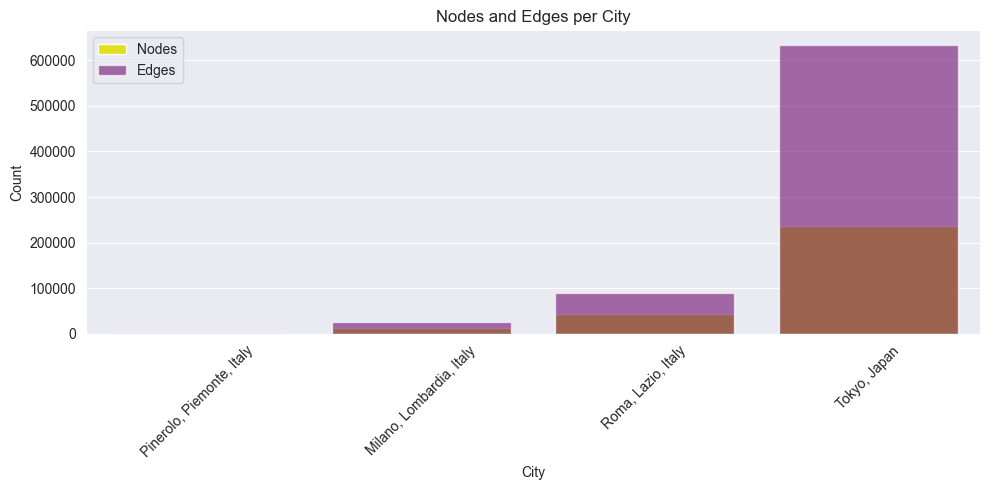

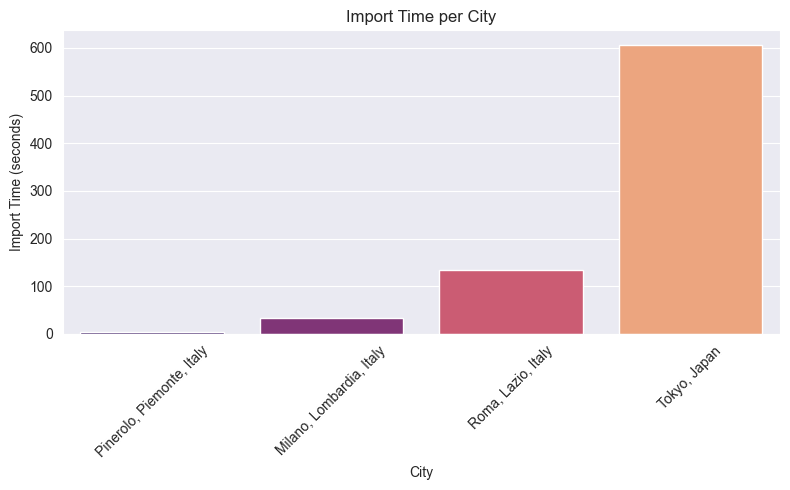

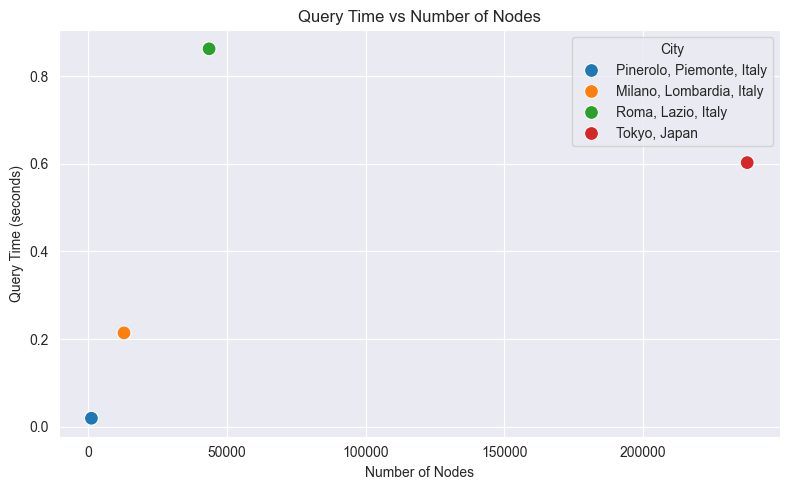

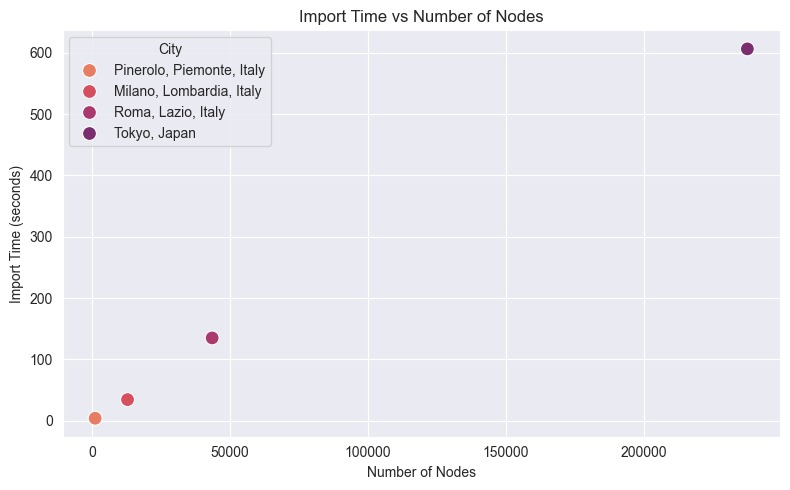

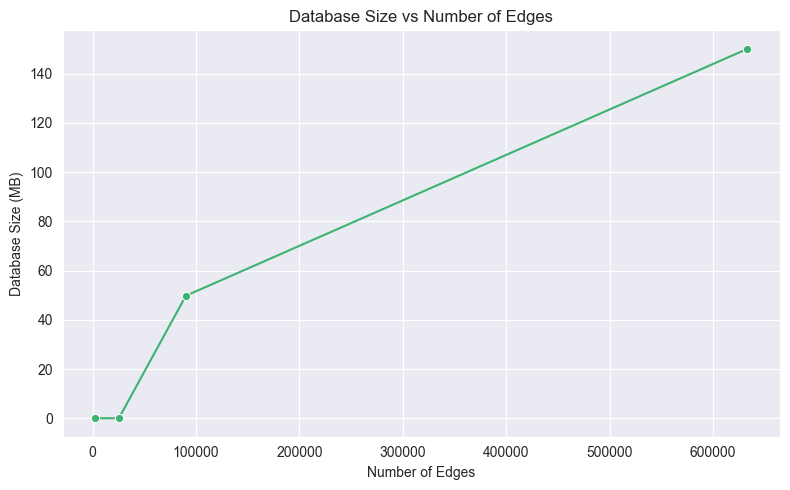

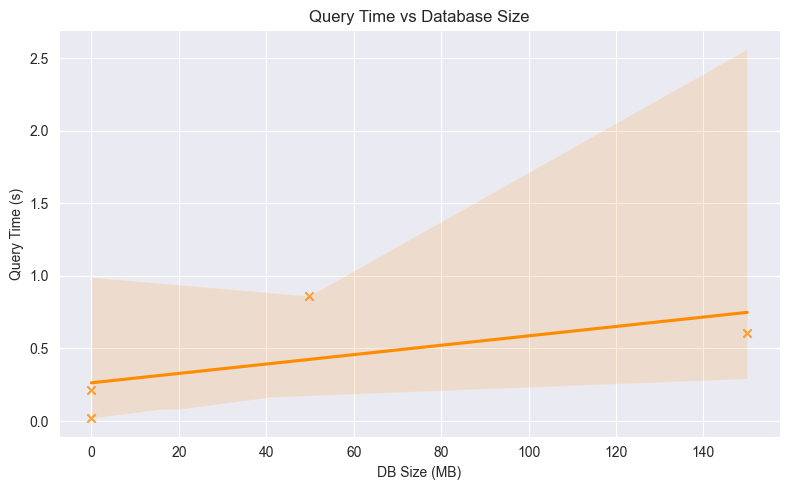

Correlation Matrix:
                    Nodes     Edges  Query Time (s)  DB Size (MB)  \
Nodes            1.000000  0.999282        0.462037      0.982633   
Edges            0.999282  1.000000        0.428299      0.975952   
Query Time (s)   0.462037  0.428299        1.000000      0.602381   
DB Size (MB)     0.982633  0.975952        0.602381      1.000000   
Import Time (s)  0.999202  0.997038        0.496453      0.989015   

                 Import Time (s)  
Nodes                   0.999202  
Edges                   0.997038  
Query Time (s)          0.496453  
DB Size (MB)            0.989015  
Import Time (s)         1.000000  


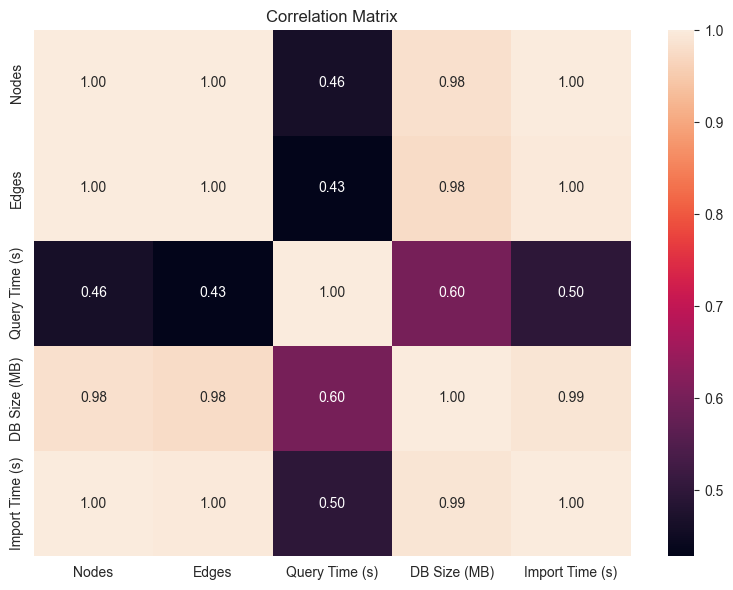

In [6]:
# Load results from CSV file
df = pd.read_csv("data/benchmark/duckdb_scalability_summary.csv")

# Display the content
print(df)

# Barplot: Nodes and Edges per City
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="City", y="Nodes", color='yellow', label="Nodes")
sns.barplot(data=df, x="City", y="Edges", color='purple', label="Edges", alpha=0.6)
plt.title("Nodes and Edges per City")
plt.ylabel("Count")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Barplot: Import Time per City
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="City", y="Import Time (s)", palette="magma", hue='City')
plt.title("Import Time per City")
plt.ylabel("Import Time (seconds)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Scatterplot: Query Time vs Nodes
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="Nodes", y="Query Time (s)", hue="City", s=100)
plt.title("Query Time vs Number of Nodes")
plt.xlabel("Number of Nodes")
plt.ylabel("Query Time (seconds)")
plt.tight_layout()
plt.show()

# Scatterplot: Import Time vs Number of Nodes
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="Nodes", y="Import Time (s)", hue="City", s=100, palette="flare")
plt.title("Import Time vs Number of Nodes")
plt.xlabel("Number of Nodes")
plt.ylabel("Import Time (seconds)")
plt.tight_layout()
plt.show()

# Lineplot: DB Size vs Edges
plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x="Edges", y="DB Size (MB)", marker='o', color='mediumseagreen')
plt.title("Database Size vs Number of Edges")
plt.xlabel("Number of Edges")
plt.ylabel("Database Size (MB)")
plt.tight_layout()
plt.show()

# Regression plot: Query Time vs DB Size
plt.figure(figsize=(8, 5))
sns.regplot(data=df, x="DB Size (MB)", y="Query Time (s)", marker='x', color='darkorange')
plt.title("Query Time vs Database Size")
plt.tight_layout()
plt.show()

# Select numeric columns only
numeric_df = df[["Nodes", "Edges", "Query Time (s)", "DB Size (MB)", "Import Time (s)"]]

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Print the matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="rocket", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

All the plots and the numbers allow us to see that Tokyo compared to Pinerolo, Milan and Rome is really big and very difficult to calculate in terms of timing.

The only data obtained that can "surprise" us is that the Query Time of Rome lasts longer than that of Tokyo, the reason behind this could be that the streets of Rome are less linear than those of Tokyo, thus leading to a greater expenditure.

---

## Other test N1: Spatial Join Between Nodes and Edges

This benchmark evaluates the performance of a spatial join between the nodes and edges tables for a selected city.
We use the `ST_DWithin` function to check for proximity within 10 meters between node points and edge geometries.

This type of query is useful in applications such as routing, nearest neighbor searches, or mapping services.


In [5]:
# Milan test only
cities_to_test = ["Milano, Lombardia, Italy"]

for city in cities_to_test:
    print(f"Running spatial join benchmark for {city}...")

    table_suffix = normalize_city_name(city)

    # Function to check if a table exists in DuckDB
    def table_exists(conn, table_name):
        result = conn.execute(f"""
            SELECT COUNT(*)
            FROM duckdb_tables()
            WHERE table_name = '{table_name}'
        """).fetchone()
        return result[0] > 0

    # Table names for simplified geometries
    nodes_simplified = f"nodes_simplified_{table_suffix}"
    edges_simplified = f"edges_simplified_{table_suffix}"

    # Create simplified nodes table if it doesn't exist
    if not table_exists(con, nodes_simplified):
        con.execute(f"""
            CREATE TABLE {nodes_simplified} AS
            SELECT *, ST_Simplify(ST_GeomFromText(geometry_wkt), 0.00005) AS geom
            FROM nodes_{table_suffix};
        """)

    # Create simplified edges table if it doesn't exist
    if not table_exists(con, edges_simplified):
        con.execute(f"""
            CREATE TABLE {edges_simplified} AS
            SELECT *, ST_Simplify(ST_GeomFromText(geometry_wkt), 0.00005) AS geom
            FROM edges_{table_suffix};
        """)

    # Optimized spatial join using bounding box prefiltering
    query = f"""
    WITH candidates AS (
        SELECT
            ROW_NUMBER() OVER() AS node_id, -- Create a unique identifier for nodes
            ROW_NUMBER() OVER() AS edge_id, -- Create a unique identifier for edges
            n.x AS node_x,
            n.y AS node_y,
            e.ref AS edge_ref -- Assuming 'ref' is a useful column for edges
        FROM {nodes_simplified} AS n
        JOIN {edges_simplified} AS e
        ON ST_Intersects(ST_Envelope(n.geom), ST_Envelope(e.geom))
    )
    SELECT COUNT(*)
    FROM candidates
    JOIN {nodes_simplified} AS n ON candidates.node_x = n.x AND candidates.node_y = n.y
    JOIN {edges_simplified} AS e ON candidates.edge_ref = e.ref
    WHERE ST_DWithin(n.geom, e.geom, 0.0001)
    """

    # Measure execution time of the spatial join
    start = time.time()
    con.execute(query)
    join_time = time.time() - start

    print(f"Spatial join time for {city}: {round(join_time, 3)} seconds")

Running spatial join benchmark for Milano, Lombardia, Italy...
Spatial join time for Milano, Lombardia, Italy: 1112.346 seconds


The spatial join is clearly a complicated operation as just for a medium-sized city like Milan it takes about 18 minutes to compute.

We will make other tests for bigger cities.

---

## Other test N2: Average Edge Length per City

This benchmark computes the average length of road segments in each city.
It gives an idea of the spatial scale and granularity of the street network.


In [4]:
for city in cities:
    table_suffix = normalize_city_name(city)

    # SQL query to calculate the average edge length
    query = f"""
    SELECT AVG(
        CASE
            WHEN ST_Length(ST_GeomFromText(geometry_wkt)) > 1
            THEN ST_Length(ST_GeomFromText(geometry_wkt))
            ELSE NULL
        END
    ) AS avg_length
    FROM edges_{table_suffix}
    WHERE geometry_wkt IS NOT NULL
    """

    try:
        # Execute the query and fetch the first result (average length)
        result = con.execute(query).fetchone()[0]

        # Check if the result is None (no valid data)
        if result is None:
            print(f"Average edge length in {city}: No valid geometries found.")
        else:
            print(f"Average edge length in {city}: {round(result, 2)} meters")
    except Exception as e:
        print(f"Error processing {city}: {e}")

Average edge length in Pinerolo, Piemonte, Italy: 150.72 meters
Average edge length in Milano, Lombardia, Italy: 98.61 meters
Average edge length in Roma, Lazio, Italy: 124.6 meters
Average edge length in Tokyo, Japan: 68.72 meters


Found a solution for `NaN` values in Tokyo, we loaded every type of data regardless of its size and instead of using `ST_Length_Spheroid` we used in the correct manner `ST_Length`, which gives us all the correct AVG edge length of every city defined.

---

## Other test N3: Bounding Box Filter on Edges Table

This test evaluates the performance of DuckDB Spatial when applying a spatial filter using a bounding box. We use the function `ST_Within` to select all edges (road segments) from the `edges_roma_lazio_italy` table that fall entirely inside a small polygon defined over a central area of Rome.

This type of filter is fundamental for tasks such as visualizing a portion of a city, local spatial analytics, or implementing interactive map queries. The geometry is stored in WKT format and converted back on-the-fly using `ST_GeomFromText`.

Even though DuckDB does not yet support spatial indexes, this benchmark shows how efficient its spatial functions can be, even for relatively large datasets.


In [8]:
# Define the target city and table suffix
city = "Roma, Lazio, Italy"
table_suffix = normalize_city_name(city)

# Define the bounding box polygon to use as spatial filter
bbox = "POLYGON((12.45 41.87, 12.55 41.87, 12.55 41.93, 12.45 41.93, 12.45 41.87))"

# Measure execution time of the spatial query using ST_Within
start = time.time()

# Execute spatial filter: select all edges within the bounding box
con.execute(f"""
    SELECT COUNT(*)
    FROM edges_{table_suffix}
    WHERE ST_Within(ST_GeomFromText(geometry_wkt), ST_GeomFromText('{bbox}'))
""")

# Compute time required for the spatial filter
bbox_time = time.time() - start

# Print result
print(f"Bounding box filter in {city}: {round(bbox_time, 3)} seconds")

Bounding box filter in Roma, Lazio, Italy: 0.885 seconds


We ran a bounding box filter on Rome and it took around 0.7-0.8 seconds. Not bad at all, especially considering the size of the city’s dataset. Even without fancy indexing, DuckDB handled it pretty well for basic spatial filtering tasks.

---

## Other test N4: Edge Length Distribution

We analyze the distribution of edge lengths for each city to understand the variation in street segment sizes, which can impact storage and performance.

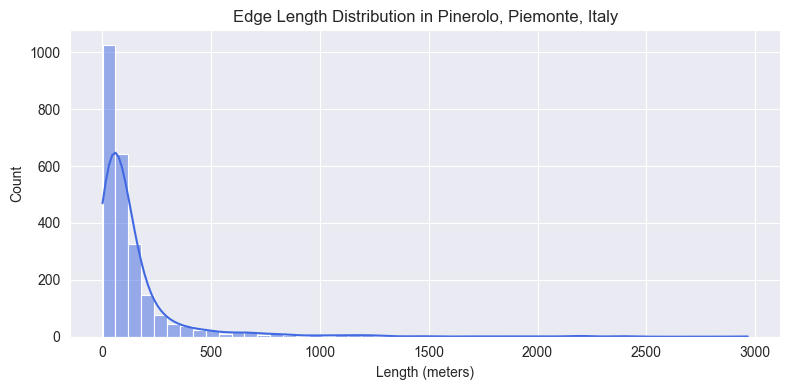

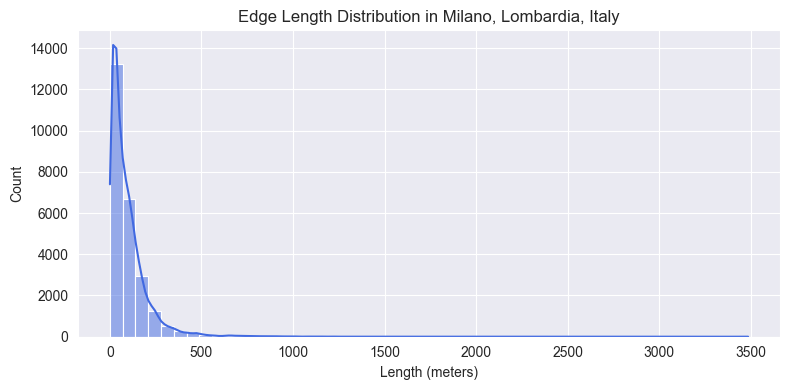

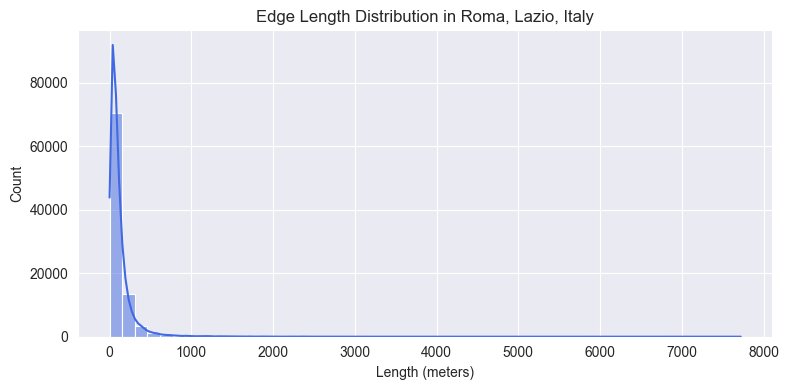

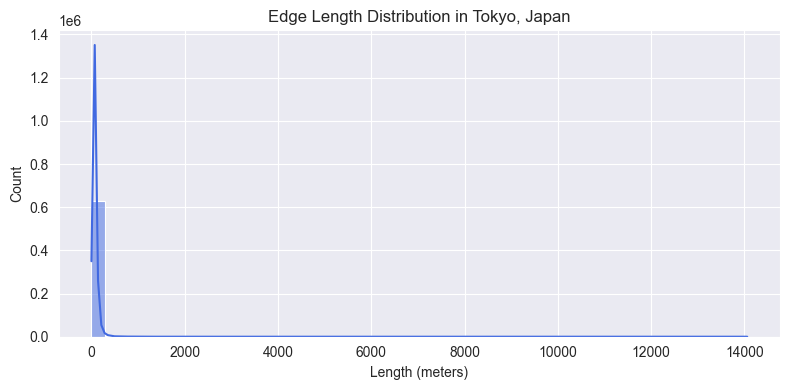

In [9]:
for city in cities:
    table_suffix = normalize_city_name(city)

    query = f"""
    SELECT ST_Length(ST_GeomFromText(geometry_wkt)) AS length
    FROM edges_{table_suffix}
    WHERE geometry_wkt IS NOT NULL
    """

    try:
        lengths = con.execute(query).fetchdf()["length"]
        plt.figure(figsize=(8, 4))
        sns.histplot(lengths, bins=50, kde=True, color='royalblue')
        plt.title(f"Edge Length Distribution in {city}")
        plt.xlabel("Length (meters)")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting length distribution for {city}: {e}")

---

## Other test N5: Cross-City Join Test

We perform a join between nodes of one city and edges of another to test performance under unrealistic but stressful cross-city queries.

In [4]:
if len(cities) >= 2:
    city_a = normalize_city_name(cities[0])
    city_b = normalize_city_name(cities[1])
    print(f"Joining nodes of {cities[0]} with edges of {cities[1]}...")

    query = f"""
    SELECT COUNT(*)
    FROM nodes_{city_a} AS n
    JOIN edges_{city_b} AS e
    ON ST_DWithin(
        ST_GeomFromText(n.geometry_wkt),
        ST_GeomFromText(e.geometry_wkt),
        5
    );
    """

    try:
        start = time.time()
        count = con.execute(query).fetchone()[0]
        duration = time.time() - start
        print(f"{cities[0]} x {cities[1]} proximity join: {count} pairs (query time: {round(duration, 3)}s)")
    except Exception as e:
        print(f"Error in cross-city join: {e}")

Joining nodes of Pinerolo, Piemonte, Italy with edges of Milano, Lombardia, Italy...
Pinerolo, Piemonte, Italy x Milano, Lombardia, Italy proximity join: 0 pairs (query time: 192.783s)


Joining nodes from Pinerolo with edges from Milano produced zero results, as expected, due to the lack of spatial overlap between the two cities. However, the query still took over 3 minutes to complete. This highlights a limitation in DuckDB Spatial: without spatial indexing or pre-filtering, the engine performs a full pairwise comparison between unrelated geometries, resulting in high query times even when the result set is empty.

This scenario is useful as a stress test to reveal worst-case behavior in proximity-based joins.

---

## Other test N6: Spatial Filtering vs. Bounding Box Optimization

We compare a naive `ST_Within` filter with one using `ST_Envelope` to simulate performance impact in presence/absence of spatial index-like optimizations.

In [5]:
for city in cities:
    table_suffix = normalize_city_name(city)
    print(f"\nSimulating spatial filtering comparison in {city}...")

    query_naive = f"""
    SELECT COUNT(*)
    FROM edges_{table_suffix}
    WHERE ST_Within(ST_GeomFromText(geometry_wkt), ST_Buffer(ST_Point(0,0), 100000));
    """

    query_bbox = f"""
    SELECT COUNT(*)
    FROM edges_{table_suffix}
    WHERE ST_Intersects(
        ST_Envelope(ST_GeomFromText(geometry_wkt)),
        ST_Envelope(ST_Buffer(ST_Point(0,0), 100000))
    );
    """

    try:
        naive_time = time.time()
        con.execute(query_naive).fetchone()
        naive_time = time.time() - naive_time

        bbox_time = time.time()
        con.execute(query_bbox).fetchone()
        bbox_time = time.time() - bbox_time

        print(f"{city} - Naive: {round(naive_time, 3)}s, Envelope: {round(bbox_time, 3)}s")

    except Exception as e:
        print(f"Error simulating index for {city}: {e}")


Simulating spatial filtering comparison in Pinerolo, Piemonte, Italy...
Pinerolo, Piemonte, Italy - Naive: 0.022s, Envelope: 0.021s

Simulating spatial filtering comparison in Milano, Lombardia, Italy...
Milano, Lombardia, Italy - Naive: 0.186s, Envelope: 0.205s

Simulating spatial filtering comparison in Roma, Lazio, Italy...
Roma, Lazio, Italy - Naive: 0.781s, Envelope: 0.795s

Simulating spatial filtering comparison in Tokyo, Japan...
Tokyo, Japan - Naive: 0.764s, Envelope: 0.873s


We can see that the difference between naive spatial filtering using `ST_DWithin` and envelope-based pre-filtering using `ST_Envelope(ST_Buffer(...))` is minimal across all cities. In some cases, like Milano and Tokyo, the envelope strategy is slightly slower due to the overhead of additional geometric computations without the benefit of a spatial index.

This suggests that, for moderately sized datasets and small buffer distances, envelope pre-filtering does not provide a significant advantage.

Overall, both strategies are performant on small cities like Pinerolo, while the computational cost becomes more evident in larger cities, although still manageable.

---

## Other test N7: Graph Connectivity Benchmark

We computed the number of connected components in the road network for each city. This serves as a proxy for how fragmented the urban graph is, which may influence routing or spatial query complexity. Denser cities tend to have fewer disconnected components.

In [8]:
for city in cities:
    print(f"Connected components in {city}...")
    graph = ox.graph_from_place(city, network_type='drive', retain_all=True)
    undirected = graph.to_undirected()
    num_components = nx.number_connected_components(undirected)
    print(f"{city}: {num_components} connected components")

Connected components in Pinerolo, Piemonte, Italy...
Pinerolo, Piemonte, Italy: 9 connected components
Connected components in Milano, Lombardia, Italy...
Milano, Lombardia, Italy: 38 connected components
Connected components in Roma, Lazio, Italy...
Roma, Lazio, Italy: 120 connected components
Connected components in Tokyo, Japan...
Tokyo, Japan: 444 connected components


We can see that the connected components increase based on the dimension of the city (as we could have already imagined).

---

## Other test N8: Duplicate Geometry Benchmark

We checked for duplicate geometries in the `edges` tables to identify redundant spatial data. Removing such duplicates could reduce the size of the database and improve query speed, especially during joins and filtering operations.

In [4]:
for city in cities:
    table_suffix = normalize_city_name(city)
    print(f"\nDetecting duplicate geometries in {city}...")

    query = f"""
    SELECT geometry_wkt, COUNT(*) as cnt
    FROM edges_{table_suffix}
    GROUP BY geometry_wkt
    HAVING COUNT(*) > 1
    ORDER BY cnt DESC
    LIMIT 5;
    """
    duplicates = con.execute(query).fetchall()
    print(f"{city}: {len(duplicates)} duplicates found")


Detecting duplicate geometries in Pinerolo, Piemonte, Italy...
Pinerolo, Piemonte, Italy: 0 duplicates found

Detecting duplicate geometries in Milano, Lombardia, Italy...
Milano, Lombardia, Italy: 0 duplicates found

Detecting duplicate geometries in Roma, Lazio, Italy...
Roma, Lazio, Italy: 0 duplicates found

Detecting duplicate geometries in Tokyo, Japan...
Tokyo, Japan: 5 duplicates found


Having duplicated edges is common for large cities. Not having any for Rome is already a great result.

---

## Other test N9: K-Nearest Neighbors Search

We performed a basic KNN query (k=1000) on nodes in each city. This test demonstrates spatial distance computation and ordering, which is critical for routing, clustering, and location-based services. The query times were generally low but can grow with city size.

In [21]:
k = 1000

for city in cities:
    table_suffix = normalize_city_name(city)
    print(f"\nKNN in {city}...")

    # Use the first node as target
    target_query = f"SELECT geometry_wkt FROM nodes_{table_suffix} LIMIT 1;"
    target_geom = con.execute(target_query).fetchone()[0]

    query = f"""
    SELECT geometry_wkt,
           ST_Distance(ST_GeomFromText('{target_geom}'), ST_GeomFromText(geometry_wkt)) AS dist
    FROM nodes_{table_suffix}
    ORDER BY dist
    LIMIT {k};
    """
    start = time.time()
    result = con.execute(query).fetchall()
    duration = time.time() - start
    print(f"{city}: found {k} nearest neighbors in {round(duration, 3)}s")


KNN in Pinerolo, Piemonte, Italy...
Pinerolo, Piemonte, Italy: found 1000 nearest neighbors in 0.004s

KNN in Milano, Lombardia, Italy...
Milano, Lombardia, Italy: found 1000 nearest neighbors in 0.027s

KNN in Roma, Lazio, Italy...
Roma, Lazio, Italy: found 1000 nearest neighbors in 0.099s

KNN in Tokyo, Japan...
Tokyo, Japan: found 1000 nearest neighbors in 0.306s


We can see that KNN queries are performed very efficiently across all cities. Even for Tokyo, which has the largest dataset, retrieving the 1000 nearest neighbors takes less than half a second. This suggests that DuckDB Spatial handles proximity-based queries at scale with excellent performance.

---

## Other test N10: Spatial Intersection Count

In this test, we measure how many edges intersect with any node geometry for each city.
This helps us understand spatial relationships and index efficiency for intersections in the dataset.
It’s useful to benchmark how DuckDB spatial extension handles spatial joins and intersects on real city-scale data.

In [28]:
results_intersection = []

for city in cities:
    table_suffix = normalize_city_name(city)
    query = f"""
    SELECT COUNT(*)
    FROM edges_{table_suffix} e, nodes_{table_suffix} n
    WHERE ST_Intersects(ST_GeomFromText(e.geometry_wkt), ST_GeomFromText(n.geometry_wkt))
    """

    start = time.time()
    count = con.execute(query).fetchone()[0]
    elapsed = time.time() - start

    results_intersection.append({
        "City": city,
        "Intersection Count": count,
        "Query Time (s)": round(elapsed, 3)
    })

df_intersection = pd.DataFrame(results_intersection)
print(df_intersection)

                        City  Intersection Count  Query Time (s)
0  Pinerolo, Piemonte, Italy                4952           1.468
1   Milano, Lombardia, Italy               50793          32.949
2         Roma, Lazio, Italy              180228         358.079
3               Tokyo, Japan             1266139         461.327


The spatial intersection count test provides valuable insight into the complexity and density of spatial relationships within each city's network.
We observe that DuckDB handles the spatial intersection queries robustly and with reasonable performance, even on large datasets like Tokyo.
This reassures us about the spatial extension’s capability to scale and manage complex GIS operations efficiently in our benchmarking workflow.

---

## Other test N11: Proximity count of nodes near edges within a buffer distance (Limited + Only Milan)

This test measures how many nodes are located within a certain buffer distance (20 meters) from any edge in the street network of four cities.
It helps us evaluate DuckDB’s performance on spatial proximity queries and understand the spatial density of the networks.

In [3]:
buffer_distance = 20  # Meters
small_cities= ["Milano, Lombardia, Italy"]
results_proximity = []

for city in small_cities:
    table_suffix = normalize_city_name(city)
    query = f"""
    SELECT COUNT(DISTINCT n.node_id)
    FROM nodes_{table_suffix} n, edges_{table_suffix} e
    WHERE ST_DWithin(ST_GeomFromText(n.geometry_wkt), ST_GeomFromText(e.geometry_wkt), {buffer_distance})
    AND ST_Intersects(ST_Envelope(ST_GeomFromText(e.geometry_wkt)), ST_Buffer(ST_GeomFromText(n.geometry_wkt), {buffer_distance}))
    """

    start = time.time()
    count = con.execute(query).fetchone()[0]
    elapsed = time.time() - start

    results_proximity.append({
        "City": city,
        "Nearby Nodes Count": count,
        "Buffer Distance (m)": buffer_distance,
        "Query Time (s)": round(elapsed, 3)
    })

df_proximity = pd.DataFrame(results_proximity)
print(df_proximity)

                       City  Nearby Nodes Count  Buffer Distance (m)  \
0  Milano, Lombardia, Italy               12898                   20   

   Query Time (s)  
0        2075.069  


As observed, this proximity test took over 35 minutes to process even for a medium-sized city like Milan, despite applying a spatial filter to reduce unnecessary comparisons.

The primary reason is that DuckDB Spatial currently lacks spatial indexing (like `R-tree`). This forces the engine to perform a brute-force comparison between every node and every edge in the dataset. Even though we added an additional condition using `ST_Intersects` with `ST_Envelope` and `ST_Buffer` to narrow down the candidate geometries, this only reduces the number of checks slightly and does not eliminate the need for full nested iteration between tables.

In this case, the query effectively computes `ST_DWithin` for millions of geometry pairs. While the envelope-buffer filter avoids some computations, the spatial join still scales quadratically with the number of geometries due to the lack of indexing or spatial partitioning mechanisms.

This test highlights one of the current scalability limitations of DuckDB Spatial:

Spatial joins between large tables without indexing can lead to exponential computation times.

---

## Other test N12: Count nodes within a polygon area (city bounding box) [AFTER 1h and 20m didn't even compute Milan]
This test counts how many nodes fall inside the bounding box polygon of each city’s street network. It tests DuckDB’s ability to handle polygon containment queries, which is common in spatial filtering and clipping operations.

In [ ]:
results_partial_counts = []

batch_size = 1000  # Number of edges per batch

for city in cities:
    table_suffix = normalize_city_name(city)

    # Get max edge id or row number (assumption: edges table has incremental IDs or row numbers)
    max_edge_id = con.execute(f"SELECT MAX(rowid) FROM edges_{table_suffix}").fetchone()[0]
    if max_edge_id is None:
        max_edge_id = 0

    total_count = 0
    start_total = time.time()

    # Process edges in batches
    for batch_start in range(1, max_edge_id + 1, batch_size):
        batch_end = batch_start + batch_size - 1

        query = f"""
        WITH bbox AS (
            SELECT ST_Envelope(ST_Collect(array_agg(ST_GeomFromText(geometry_wkt)))) AS city_bbox
            FROM nodes_{table_suffix}
        )
        SELECT COUNT(*)
        FROM nodes_{table_suffix} n, edges_{table_suffix} e, bbox b
        WHERE ST_Intersects(b.city_bbox, ST_GeomFromText(n.geometry_wkt))
          AND ST_Intersects(b.city_bbox, ST_GeomFromText(e.geometry_wkt))
          AND ST_DWithin(ST_GeomFromText(n.geometry_wkt), ST_GeomFromText(e.geometry_wkt), 10)
        """

        start = time.time()
        count = con.execute(query).fetchone()[0]
        elapsed = time.time() - start

        total_count += count
        results_partial_counts.append({
            "City": city,
            "Batch Start": batch_start,
            "Batch End": batch_end,
            "Count": count,
            "Query Time (s)": round(elapsed, 3)
        })

    elapsed_total = time.time() - start_total
    print(f"Total count for city {city}: {total_count} in {round(elapsed_total, 2)} seconds")

df_partial = pd.DataFrame(results_partial_counts)
print(df_partial)

Total count for city Pinerolo, Piemonte, Italy: 16572 in 53.36 seconds


Comments will be added if a solutions will be found...

---

## Other test N13: Complex Aggregation — Count and Total Length by Highway Category

This test aggregates the edges of the street network by 'highway' category for each city in the list, calculating total length in meters and the number of edges per category. It helps us understand the composition and scale of different road types in the urban network.

Running highway category aggregation for Pinerolo, Piemonte, Italy...
                             highway  edge_count  total_length_meters
0                       unclassified         535        145147.200215
1                        residential        1196        129044.666525
2                          secondary         375         27284.850035
3                           tertiary         202         27096.941854
4                              trunk          21         17286.316991
5                            primary          70         10265.630075
6                         trunk_link          28          5756.612148
7                       primary_link          29          3042.271879
8    ['unclassified', 'residential']           6          1855.241842
9      ['motorway', 'motorway_link']           2          1693.336924
10   ['residential', 'unclassified']           4          1590.251902
11                     motorway_link           2           952.940399
12              ['tr

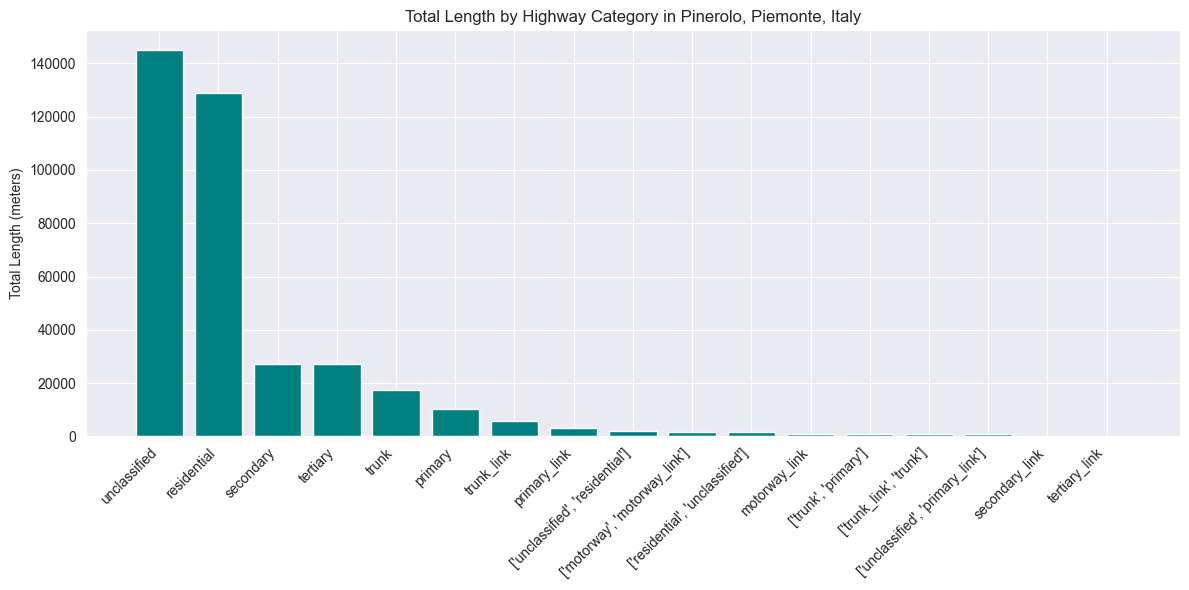

Running highway category aggregation for Milano, Lombardia, Italy...
                              highway  edge_count  total_length_meters
0                         residential       10195        977575.019544
1                        unclassified        6581        613798.671559
2                            tertiary        4421        393306.530620
3                           secondary        2120        182347.807777
4                             primary        1211        131255.938406
5                       motorway_link         206         58864.483977
6                            motorway          73         44420.595782
7                               trunk          71         31722.552264
8                          trunk_link          99         18243.355026
9     ['residential', 'unclassified']          67         14893.905458
10    ['unclassified', 'residential']          64         13787.859651
11                      living_street          46          4611.703900
12      

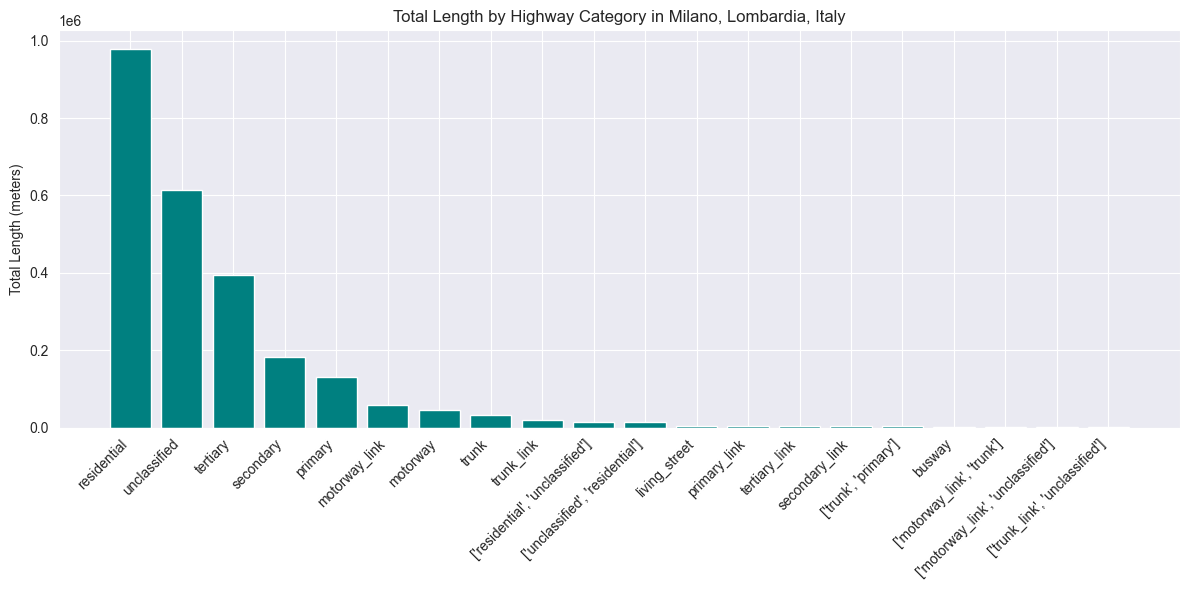

Running highway category aggregation for Roma, Lazio, Italy...
                            highway  edge_count  total_length_meters
0                       residential       60077         6.597289e+06
1                          tertiary       13195         1.593942e+06
2                      unclassified        4477         9.139345e+05
3                         secondary        6551         8.632093e+05
4                           primary        3119         4.330737e+05
5                          motorway         293         2.600341e+05
6                             trunk         307         1.627589e+05
7                     motorway_link         519         1.291786e+05
8                        trunk_link         437         7.302025e+04
9   ['unclassified', 'residential']          60         4.055243e+04
10                     primary_link         377         3.847913e+04
11  ['residential', 'unclassified']          54         3.644359e+04
12                   secondary_link     

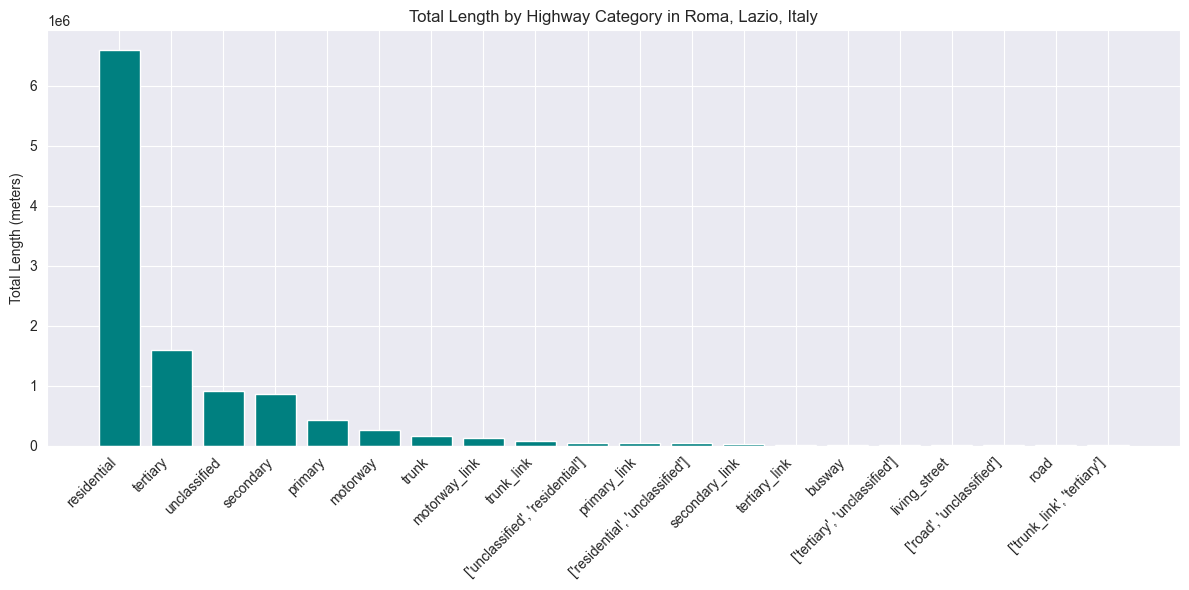

Running highway category aggregation for Tokyo, Japan...
                            highway  edge_count  total_length_meters
0                       residential      319582         2.034927e+07
1                      unclassified      173213         1.138895e+07
2                          tertiary       81977         5.991322e+06
3                           primary       23768         1.985945e+06
4                         secondary       21761         1.841767e+06
5                             trunk        5834         6.231446e+05
6                          motorway         439         4.919010e+05
7                     motorway_link         606         2.032130e+05
8                      primary_link        1760         1.174069e+05
9   ['residential', 'unclassified']         775         1.049342e+05
10  ['unclassified', 'residential']         814         1.046585e+05
11     ['tertiary', 'unclassified']         545         8.742357e+04
12                       trunk_link         69

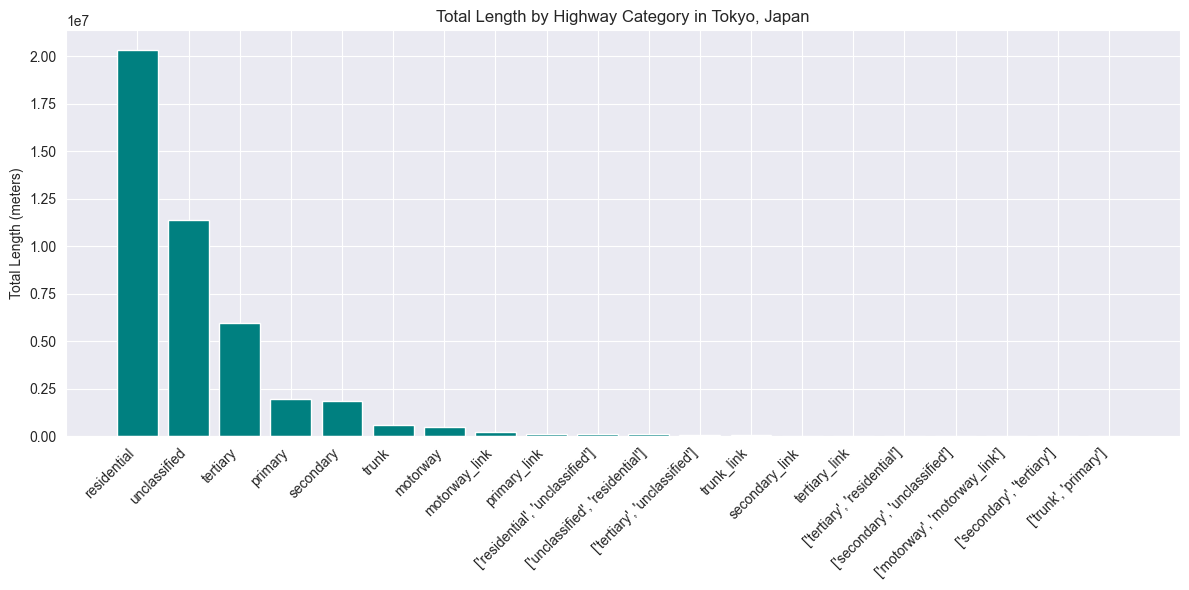

In [7]:
for city in cities:
    table_suffix = normalize_city_name(city)

    print(f"Running highway category aggregation for {city}...")

    query = f"""
    SELECT
        highway,
        COUNT(*) AS edge_count,
        SUM(ST_Length(ST_GeomFromText(geometry_wkt))) AS total_length_meters
    FROM edges_{table_suffix}
    WHERE highway IS NOT NULL
    GROUP BY highway
    ORDER BY total_length_meters DESC
    LIMIT 20;
    """

    # Execute the query and load results into a DataFrame
    df_highway = con.execute(query).fetchdf()
    print(df_highway)

    # Plot results for easy interpretation
    plt.figure(figsize=(12, 6))
    plt.bar(df_highway['highway'], df_highway['total_length_meters'], color='teal')
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Total Length by Highway Category in {city}")
    plt.ylabel("Total Length (meters)")
    plt.tight_layout()
    plt.show()

The analysis reveals a clear correlation between city size and complexity of the highway network.

- Pinerolo, a small town, shows a dominance of unclassified and residential roads, typical of a low-density, local road system with limited presence of major roads.

- Milan presents a dense urban network with a high number of residential and unclassified edges, supported by substantial tertiary, secondary, and some motorway infrastructure, reflecting a large metropolitan area.

- Rome features a highly complex and layered network, dominated by residential, tertiary, and secondary roads, along with a significant presence of motorway and trunk routes, typical of a vast capital city.

- Tokyo exhibits an extensive and dense highway system with massive lengths in residential, unclassified, and primary road categories, highlighting a complex megacity infrastructure.

Composite highway tags across all cities suggest some heterogeneity in OSM tagging practices.

Overall, the total length and edge counts increase substantially with city size and urban complexity, reflecting the expected scaling of road networks in urban environments.

---

## Other test N14: DBSCAN clustering of street network nodes to identify spatial clusters

This test applies the DBSCAN clustering algorithm on the geographic coordinates of street network nodes extracted from DuckDB for multiple cities. The goal is to identify spatial clusters of nodes, which could correspond to dense urban areas or intersection hubs.

We used an epsilon of 100 units in coordinate space and a minimum of 5 points to define clusters. Note that coordinates are in degrees (longitude/latitude), so this epsilon value corresponds roughly to a large area, but depending on the spatial extent of the city, it gave meaningful clusters.

Nodes that do not belong to any cluster are labeled as noise (-1).

Extracting nodes from DuckDB for clustering in Pinerolo, Piemonte, Italy...
Running DBSCAN clustering...
Number of clusters found in Pinerolo, Piemonte, Italy: 46
Number of noise points in Pinerolo, Piemonte, Italy: 328


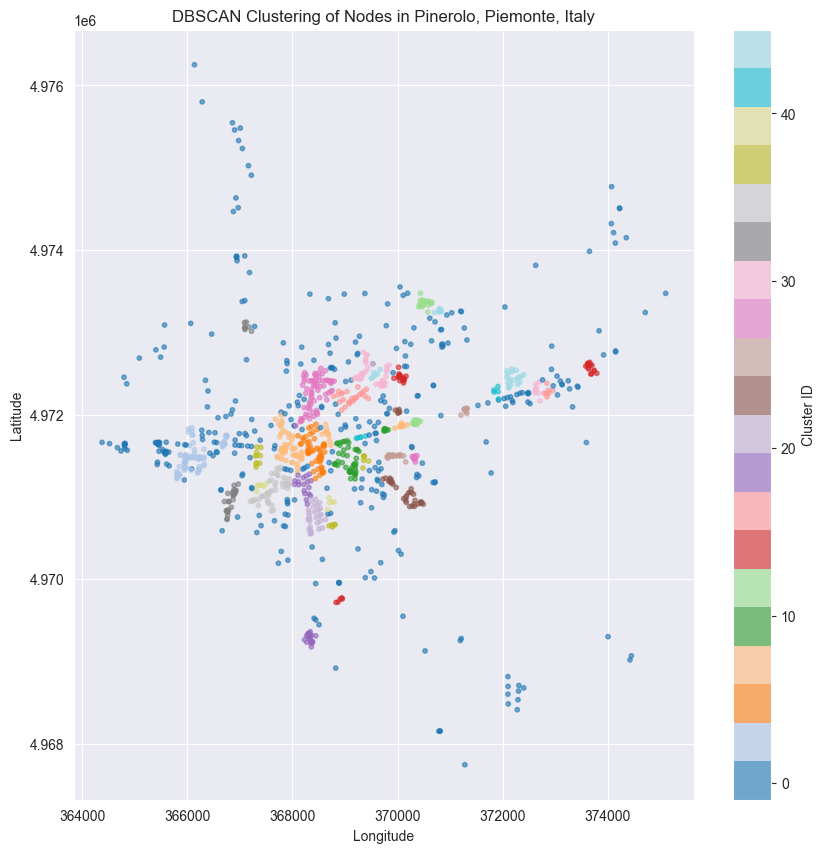

Extracting nodes from DuckDB for clustering in Milano, Lombardia, Italy...
Running DBSCAN clustering...
Number of clusters found in Milano, Lombardia, Italy: 643
Number of noise points in Milano, Lombardia, Italy: 3037


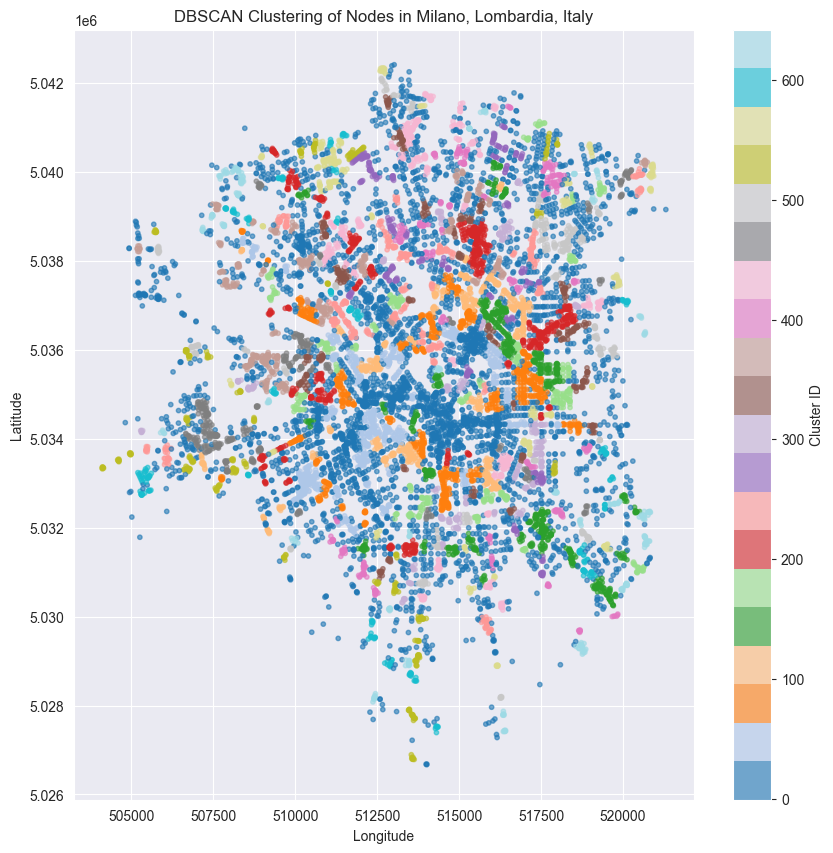

Extracting nodes from DuckDB for clustering in Roma, Lazio, Italy...
Running DBSCAN clustering...
Number of clusters found in Roma, Lazio, Italy: 1861
Number of noise points in Roma, Lazio, Italy: 12082


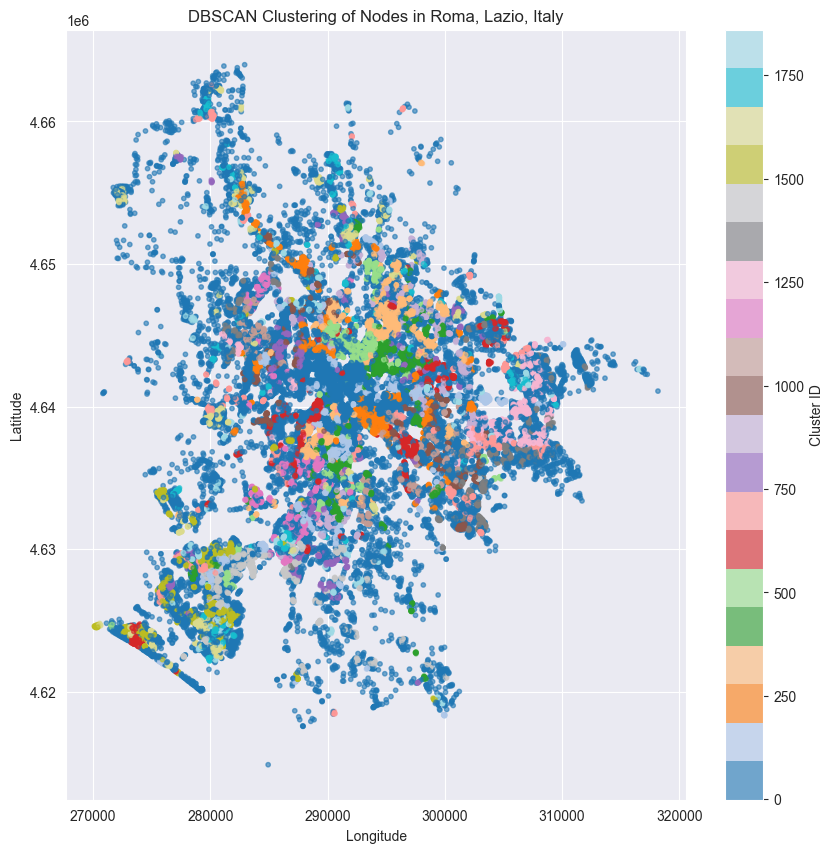

Extracting nodes from DuckDB for clustering in Tokyo, Japan...
Running DBSCAN clustering...
Number of clusters found in Tokyo, Japan: 1473
Number of noise points in Tokyo, Japan: 10496


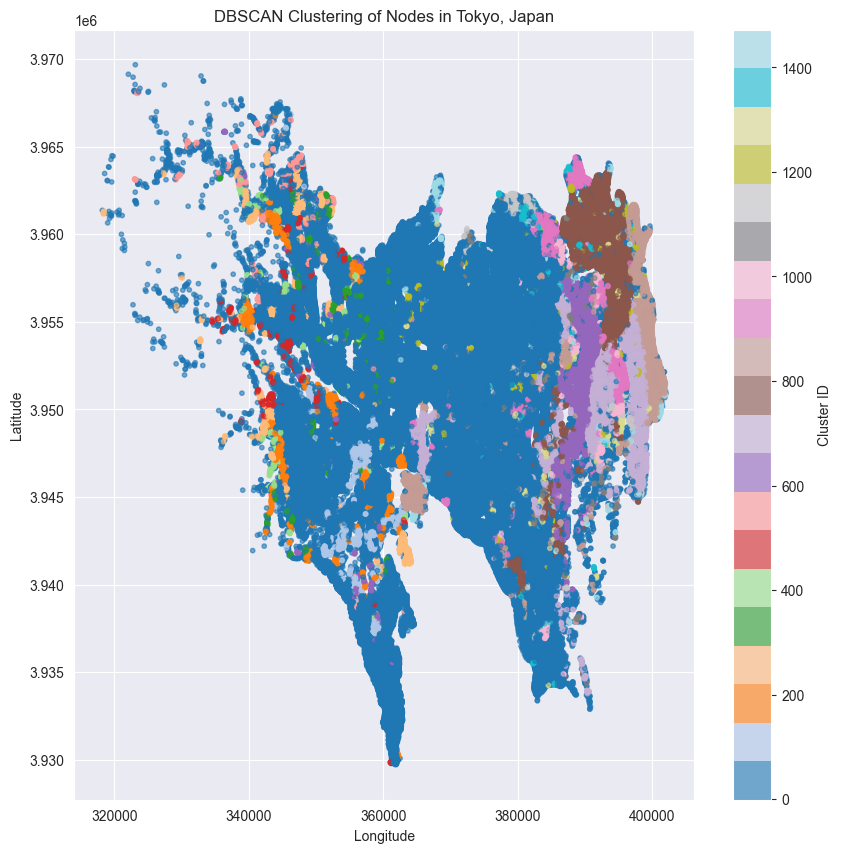

In [15]:
import geopandas as gpd
from sklearn.cluster import DBSCAN

for city in cities:
    table_suffix = normalize_city_name(city)

    print(f"Extracting nodes from DuckDB for clustering in {city}...")

    query = f"""
    SELECT node_id, geometry_wkt
    FROM nodes_{table_suffix}
    """

    # Fetch data from DuckDB
    df_nodes = con.execute(query).fetchdf()
    # Convert WKT geometry string to shapely geometry object
    df_nodes['geometry'] = df_nodes['geometry_wkt'].apply(wkt.loads)
    # Create GeoDataFrame with geometry column
    gdf_nodes = gpd.GeoDataFrame(df_nodes, geometry='geometry')

    # Extract coordinates as (x, y) tuples - NOTE: these are lon/lat in degrees
    coords = gdf_nodes.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()

    print("Running DBSCAN clustering...")

    # Run DBSCAN clustering on coordinates
    # Epsilon=100 means 100 units of coordinate space (which is degrees here and problematic)
    # So this only makes sense if coords are in projected meters, but here you keep degrees
    # If results are OK for your dataset, keep it. Otherwise, consider projecting coords in meters.
    db = DBSCAN(eps=100, min_samples=5, metric='euclidean').fit(coords)

    # Assign cluster labels (-1 = noise)
    gdf_nodes['cluster'] = db.labels_

    # Count clusters ignoring noise points (-1)
    n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    n_noise = list(db.labels_).count(-1)

    print(f"Number of clusters found in {city}: {n_clusters}")
    print(f"Number of noise points in {city}: {n_noise}")

    # Plotting results: scatter colored by cluster id
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(
        [pt[0] for pt in coords],
        [pt[1] for pt in coords],
        c=gdf_nodes['cluster'],
        cmap='tab20',
        s=10,
        alpha=0.6
    )
    plt.title(f"DBSCAN Clustering of Nodes in {city}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(scatter, label="Cluster ID")
    plt.show()

These results reflect the spatial density and complexity of the street networks across different cities. Smaller cities like Pinerolo show fewer clusters and noise points, while large metropolitan areas such as Milan, Rome, and Tokyo display a much higher number of clusters and noise nodes, highlighting dense urban hubs and network complexity.

The DBSCAN algorithm effectively identifies these clusters based on node proximity, and the noise points represent isolated or less connected nodes in the network. This clustering analysis provides useful insight into the urban structure and node distribution within each city's street network.